# Embedding and recovering of Water Marks in pictures
## By Pedro Iniguez  Huerta

This notebook provides a method to hide a water mark into a picture inperceptible for humans. Prior to explaining the mechanism let's add some background:

An image is a bidimensional array where the elements are as follow:
- **Blank and White** ==> Boolean value  where 0 means black and 1 means White.


    640 x 480 image ==> (640/480)/8 bytes

- **Gray scales** ==> byte value, ranging from 0 (black) until 255(white) and having several scales of gray.


    640 x 480 image ==> (640/480) bytes

- **Color** ==> <RGB> byte array, each element consists of 3 bytes wich contains the intensities of Red,Green and Blue colors.


    640 x 480 image ==> (640/480)*3 bytes


The difference in color or intensity for gray scales or color images between 0 (nothing) and 255(full) is huge. But the intensity between 0,1,2 and 3 is not significant. Same case for 96,97,98 and 99 or 252,253,254 and 255.

This algortithm takes advantage of this characteristic. Users can select any range to sacrify the color. In this specific example it sacrifies the highest white color to use 2 bits for storing the water mark. In order words the highest scale supported will be 251 and the 2 less significant bits will be cleared with zeros and will be used to store a blank and white water mark.

## Import libraries

In [95]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
import os

## Declare global variables and constants

In [96]:
DISPLAY_TIME = 3000                      # slide display time
WIDTH        = 640                       # image width
HEIGHT       = 480                       # image height
WHITE        = (255,255,255)             # White color
FONT         = cv2.FONT_HERSHEY_SIMPLEX  # text on picture font
WINX         = 10                        # X position where the text will start
WINY         = 20                        # Y position where the text will start
ximg         = 0                         # altered image copy
PLOT_IMAGE   = True                      # Disabling image plotting feature

## Read images from Google Drive

In [97]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
IMAGE_PATH="/content/drive/My Drive/Shared/WaterMark/"
print(os.listdir(IMAGE_PATH))

Mounted at /content/drive
['spiderman.jpg', 'basePictureMouse.jpg', 'hormigaatomica.jpeg', 'basePicture.jpg', 'thanos.jpeg']


## Function for reading images from disk and resizing them

In [98]:
def readImage(fileName, forceSize = True, width = WIDTH, height = HEIGHT):
    img = cv2.imread(fileName, 1 )

    ##########################################################################
    # Force size
    ##########################################################################
    if forceSize == True:
        img = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)

    return img

## Function for plotting images

In [99]:
def displayImage(img, title = "title", x = 10, y = 20, waitTime = 0, plotImage = True, keepImage = False):
    global ximg
    ximg = img.copy()
    ##########################################################################
    # Display image in opencv Window
    ##########################################################################

## USE THIS FOR GOOGLE COLLAB    
    cv2_imshow(img)

##  USE THIS FOR JUPYTER
#    cv2.imshow(title, ximg)
#    cv2.moveWindow(title,x,y)    
#    cv2.waitKey(waitTime)
    
    ##########################################################################
    # Display images in matplolib
    ##########################################################################
    if keepImage == False:
        cv2.destroyAllWindows()

    ##########################################################################
    # Display images in matplolib
    ##########################################################################
    if plotImage == True:
        plt.subplot(221),plt.imshow(img),plt.title(title)
        plt.show()

## Function for adding text to images

In [100]:
def applyText(img, text="", x = 1, y = 25, color = WHITE):
    global FONT
    # Clone the image before altering it
    im = img.copy()
    cv2.putText(im,text,(x,y), FONT, 1,color,1,cv2.LINE_AA)
        
    return im

## cv2 Function for applying black and white water mark

In [101]:
def applyMask(img, mask):
    return cv2.bitwise_not(img,img,mask = mask)

## function for applying water mark taking advantage of 3 less significant bits

In [102]:
def applyWaterMark(img, mask):
    wm = img.copy()
    height, width, channels = img.shape
    for j in range(1, height-1):
        for i in range(1, width-1):
            if mask[j,i] > 5:
                if wm[j,i][0] > 255:
                    wm[j,i][0] = 254
                else:
                    wm[j,i  ][0] = wm[j,i  ][0] & 0xFE
                    wm[j,i+1][0] = wm[j,i+1][0] & 0xFE
                    wm[j,i-1][0] = wm[j,i-1][0] & 0xFE

                if wm[j,i][1] > 255:
                    wm[j,i][1] = 254
                else:
                    wm[j,i  ][1] = wm[j,i  ][1] & 0xFE
                    wm[j,i+1][1] = wm[j,i+1][1] & 0xFE
                    wm[j,i-1][1] = wm[j,i-1][1] & 0xFE

                if wm[j,i ][2] > 255:
                    wm[j,i][2] = 254
                else:
                    wm[j,i  ][2] = wm[j,i  ][2] & 0xFE
                    wm[j,i+1][2] = wm[j,i+1][2] & 0xFE
                    wm[j,i-1][2] = wm[j,i-1][2] & 0xFE

    return wm 

function for extracting water mark from the 3 less significant bits

In [103]:
def extractWaterMark(img, mask):
    wm = mask.copy()
    height, width, channels = img.shape
    for j in range(1, height-1):
        for i in range(1, width-1):
            wm[j,i] = 0
            if mask[j,i] > 5:
                if (img[j,i][0]  == 254) and (img[j,i][1]  == 254) and (img[j,i][2]  == 254):
                    wm[j,i] = 255
                elif (img[j,i][0] & 0x01 == 0) and (img[j,i+1][0] & 0x01 == 0) and (img[j,i-1][0] & 0x01 == 0) and\
                   (img[j,i][1] & 0x01 == 0) and (img[j,i+1][1] & 0x01 == 0) and (img[j,i-1][1] & 0x01 == 0) and\
                   (img[j,i][2] & 0x01 == 0) and (img[j,i+1][2] & 0x01 == 0) and (img[j,i-1][2] & 0x01 == 0):
                    wm[j,i] = 255
    return wm 

## Function to read a black and white image containing the mask

In [104]:
def extractMask(fileName, l1, l2):
    ##########################################################################
    # Read the image
    ##########################################################################
    img = cv2.imread(fileName, 1 )

    ##########################################################################
    # Extract the mask by converting image in gray scale and applying threshold
    ##########################################################################
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(gray, l1, l2, cv2.THRESH_BINARY)

    height, width = mask.shape

    for j in range(0, height):
        for i in range(0, width):
            if mask[j,i] > 5:
                mask[j,i] = 255
            elif mask[j,i]:
                mask[j,i] = 0
    
    return img, mask

## Function to check if the images has embedded the mask

In [105]:
def compareMasks(mask1, mask2):
    height, width = mask1.shape
    mask = mask1.copy()
    
    for j in range(0, height):
        for i in range(0, width):
            if mask1[j,i] == mask2[j,i]:
                mask[j,i] = 0
            elif mask[j,i]:
                mask[j,i] = 255
    
    return mask

## Function to read image, apply text to it and display it

In [106]:
def readImageAndDisplay(fileName, forceSize = True, width = WIDTH, height = HEIGHT,
                        text = "", x = 1, y = 25, color = WHITE, 
                        title = "", xt = 10, yt = 20, waitTime = 0, plotImage = True, keepImage = False):
    img = readImage(fileName)
    imgt = applyText(img, text=text, x = x, y = y, color = color)
    displayImage(imgt, title = fileName, waitTime = waitTime, plotImage = plotImage, keepImage = keepImage)
    return img, imgt

## Function to read and image and look for the water mark on it.

In [107]:
def analizeImage(embeddedWaterMark, originalImage, original_mask):
    displayImage(originalImage, title = "Image to be analyzed", x = WINX, y = WINY, waitTime = DISPLAY_TIME, plotImage = PLOT_IMAGE,
                 keepImage = True)
    
    extractedWaterMark = extractWaterMark(embeddedWaterMark, original_mask)
    extractedWaterMarkMask = applyText(extractedWaterMark, text = "extracted water mark", x = 1, y = 25, color = WHITE)
    displayImage(extractedWaterMarkMask, title = "extracted water mark", x = WINX+600, y = WINY, waitTime = DISPLAY_TIME, plotImage = PLOT_IMAGE,
                 keepImage = True)
    diffMask = compareMasks(original_mask, extractedWaterMark)
    diffMaskT = applyText(diffMask, text = "Differences between masks", x = 1, y = 25, color = WHITE)
    displayImage(diffMaskT, title = "Differences between masks", x = WINX, y = WINY+350, waitTime = DISPLAY_TIME, plotImage = PLOT_IMAGE,
                 keepImage = True)

    colorDiff = embeddedWaterMark - originalImage
    colorDiffT = applyText(colorDiff, text = "Color Picture Differences", x = 1, y = 25, color = WHITE)
    displayImage(colorDiffT, title = "Color Picture Differences", x = WINX+600, y = WINY+350, waitTime = DISPLAY_TIME, plotImage = PLOT_IMAGE,
                 keepImage = False)

## Main control function

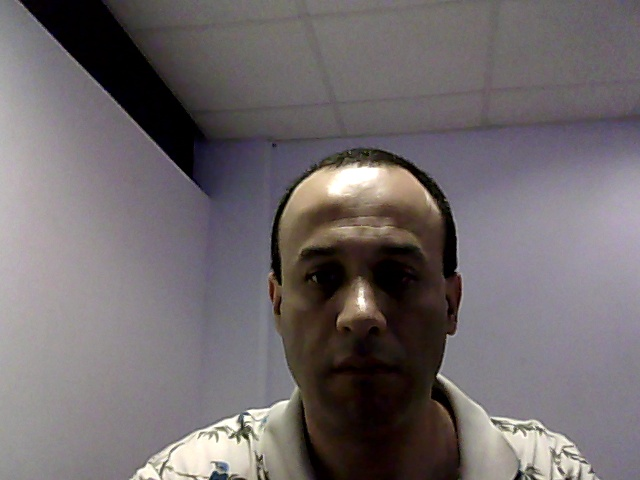

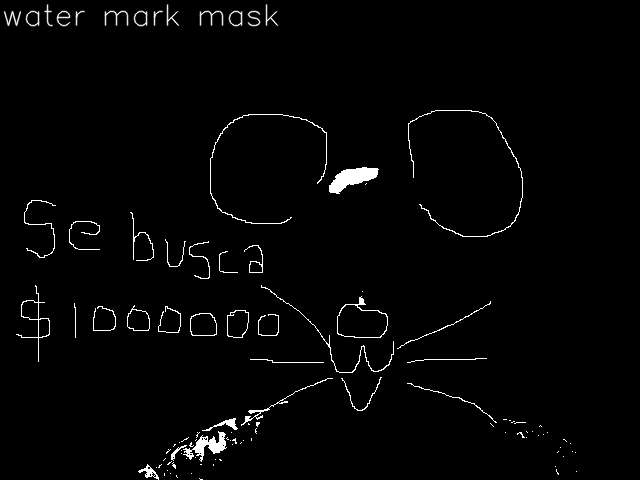

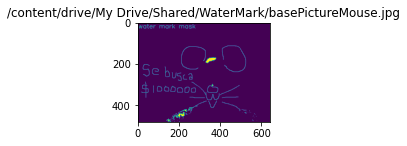

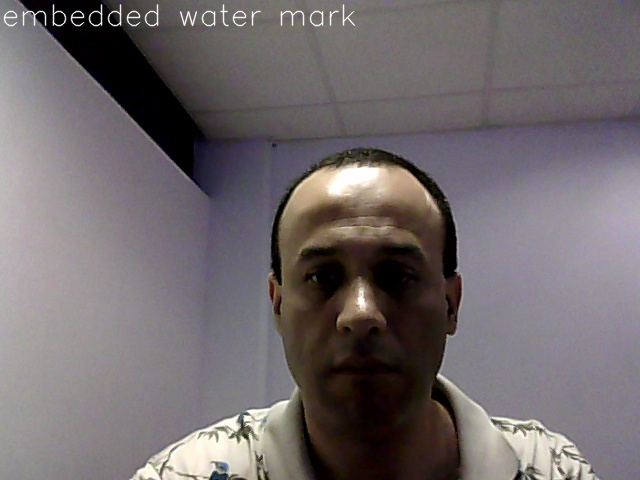

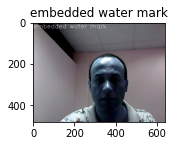

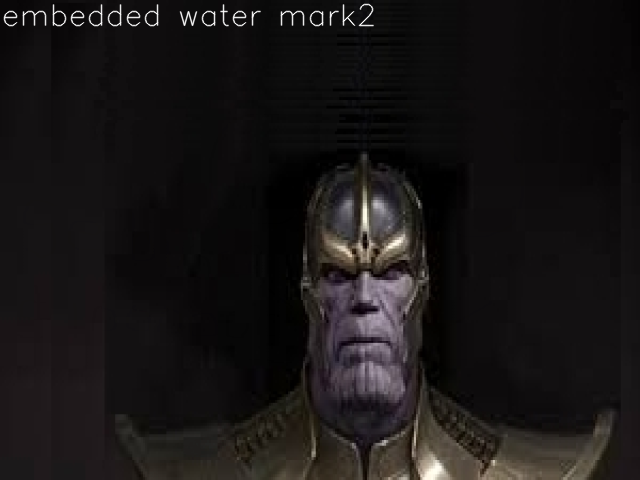

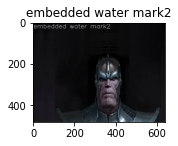

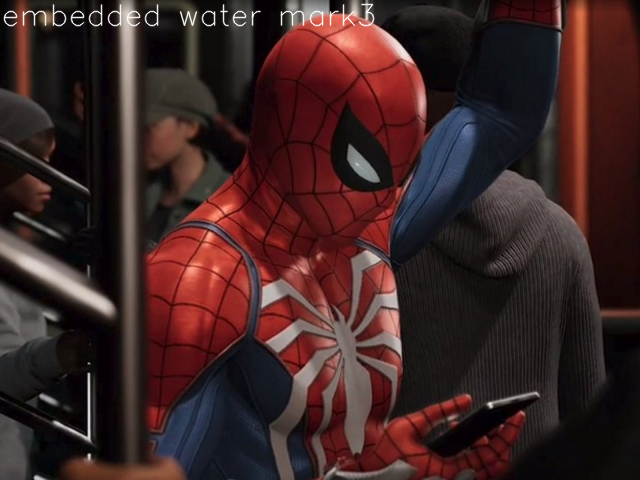

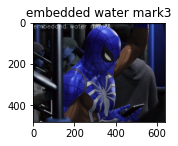

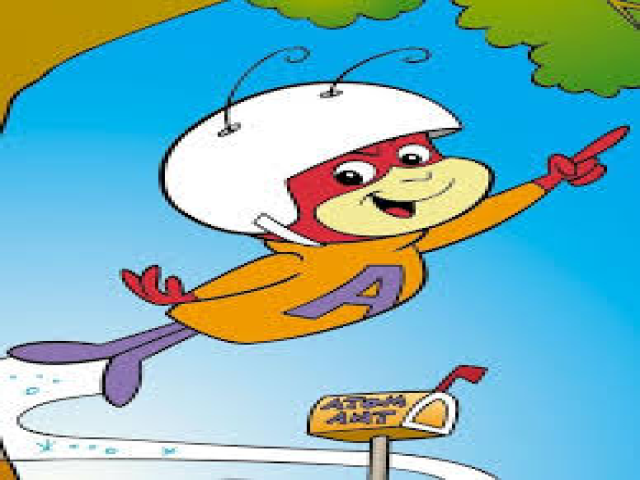

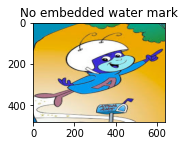

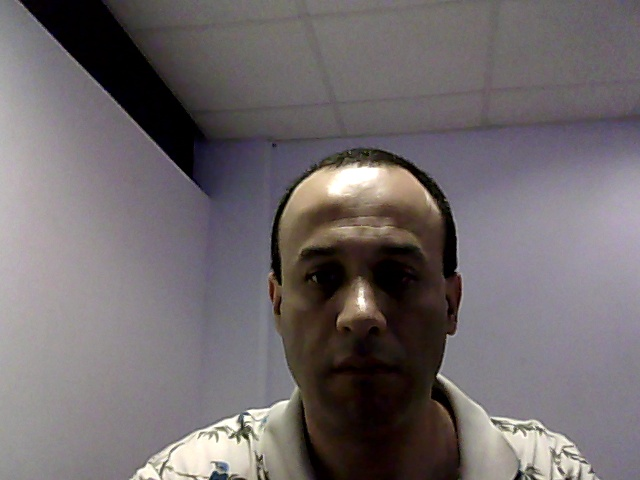

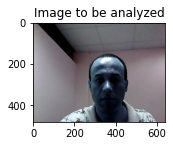

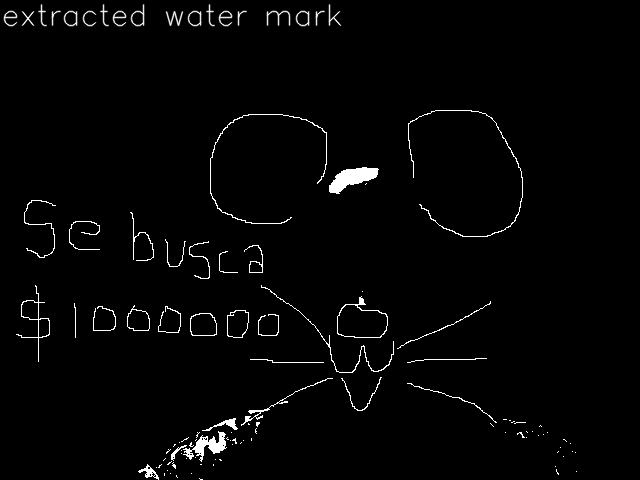

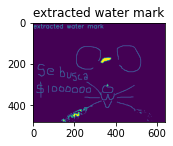

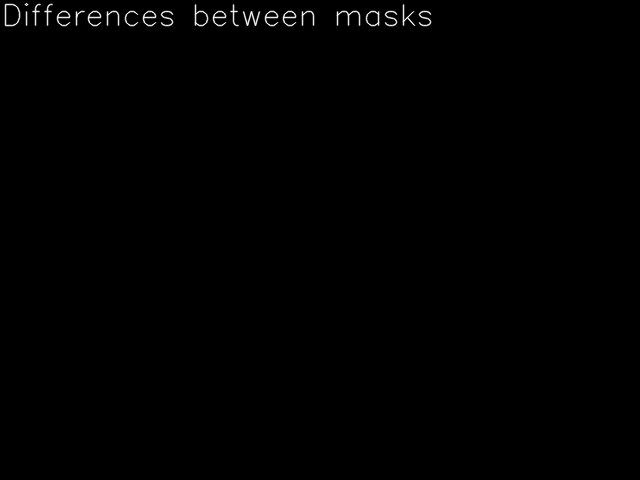

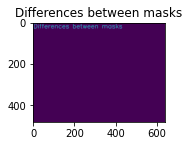

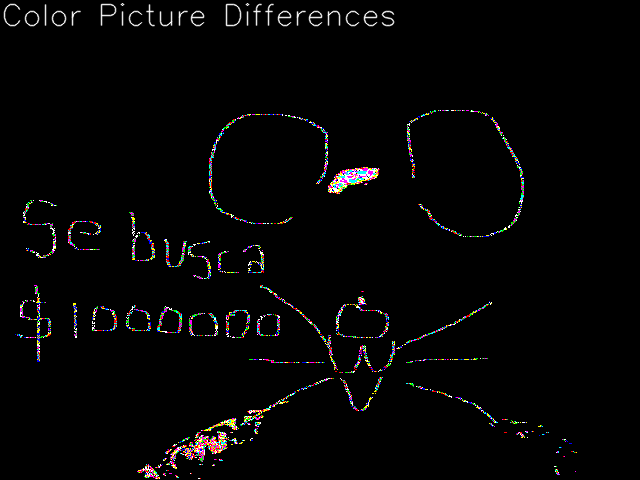

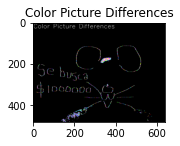

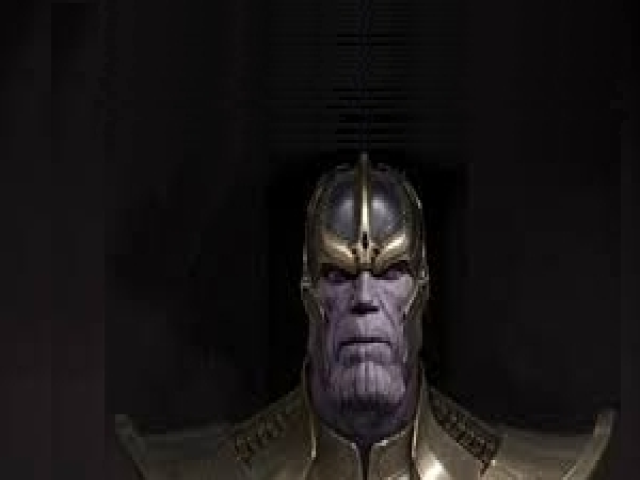

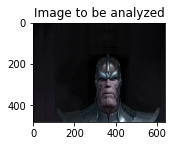

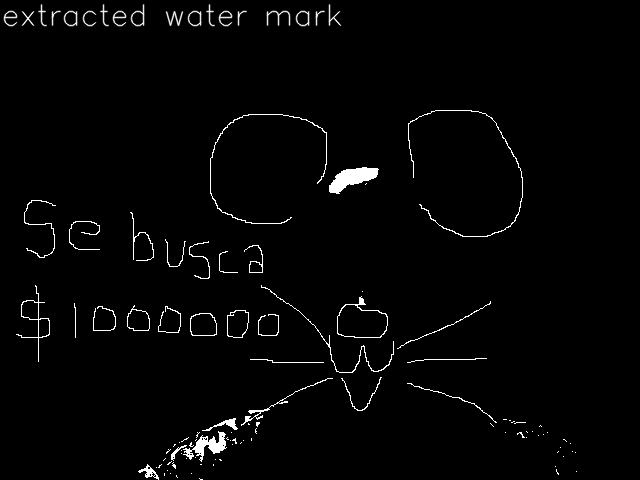

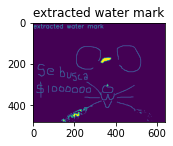

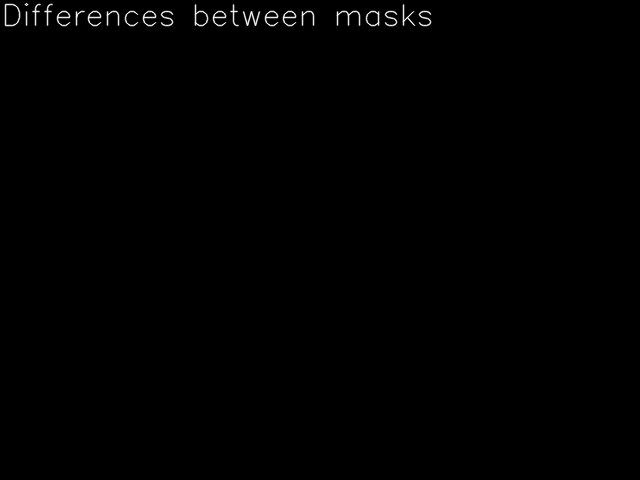

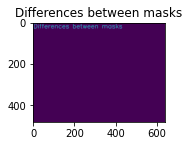

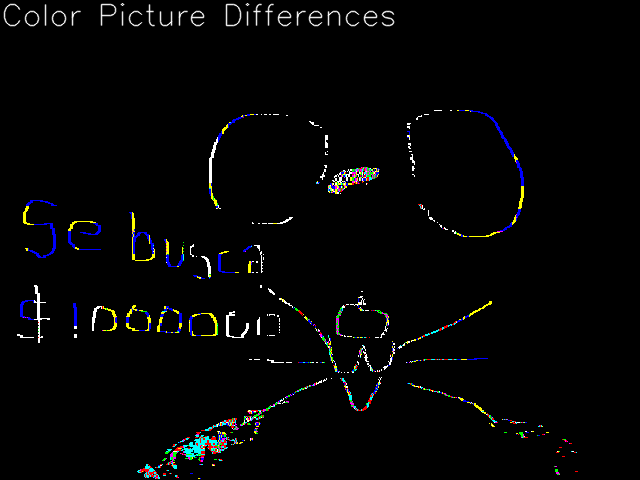

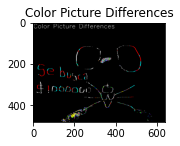

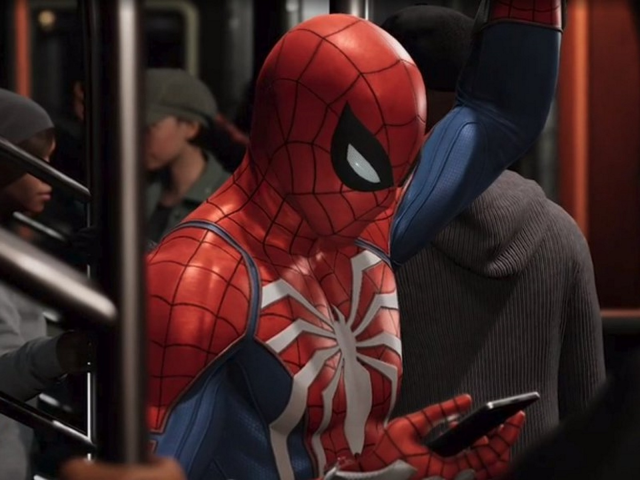

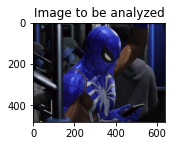

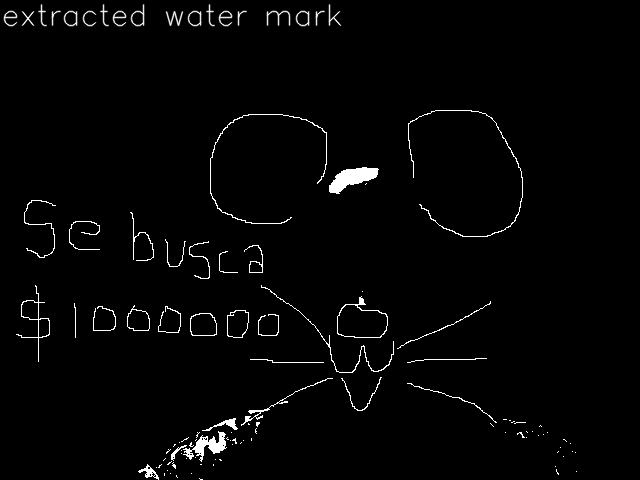

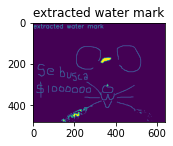

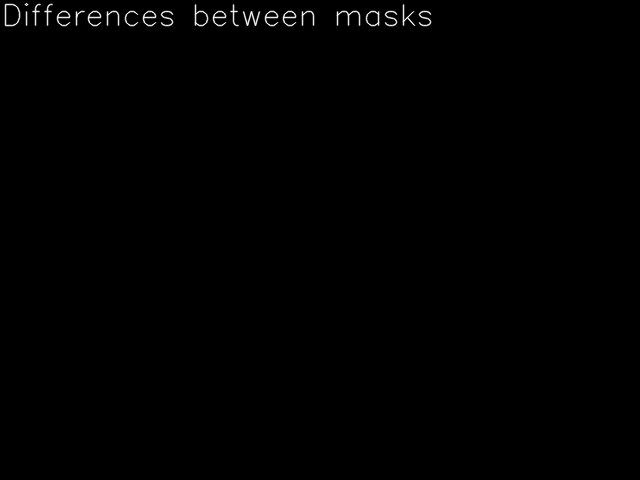

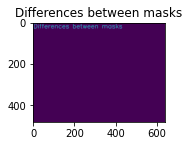

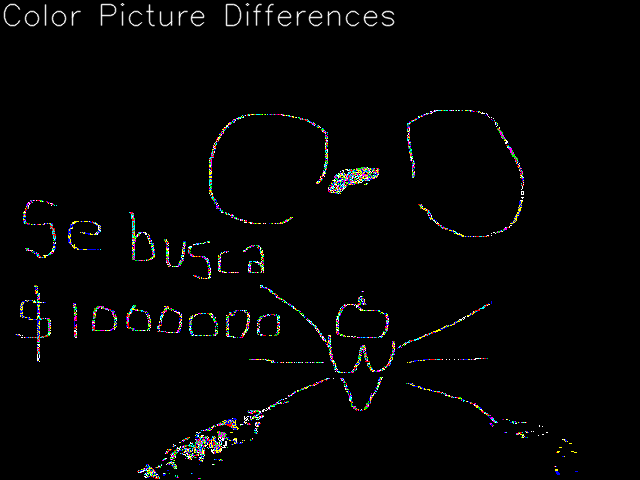

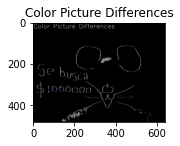

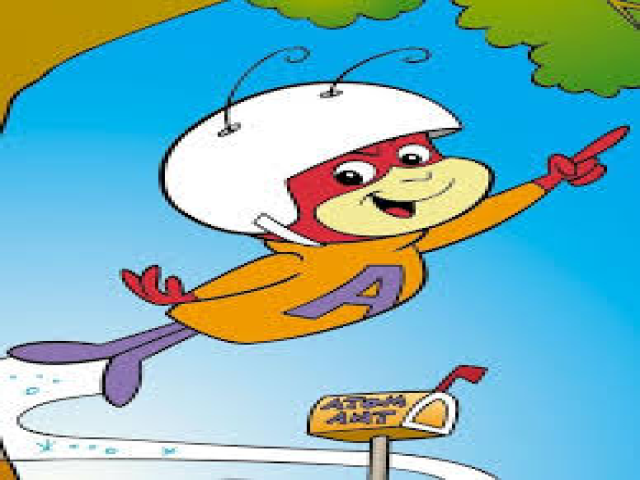

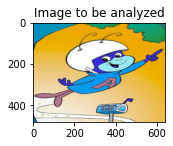

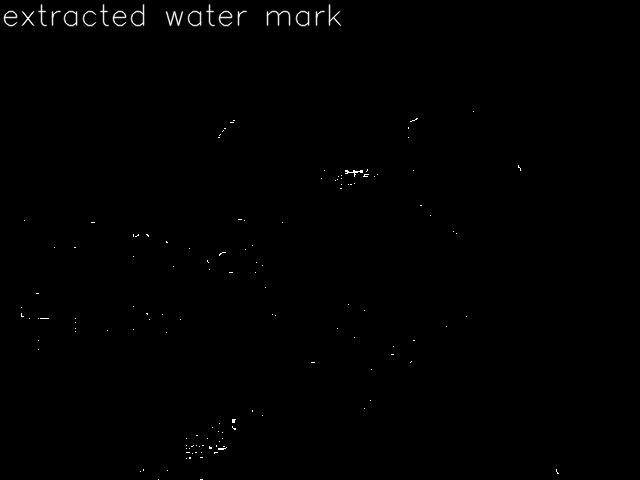

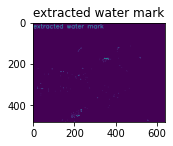

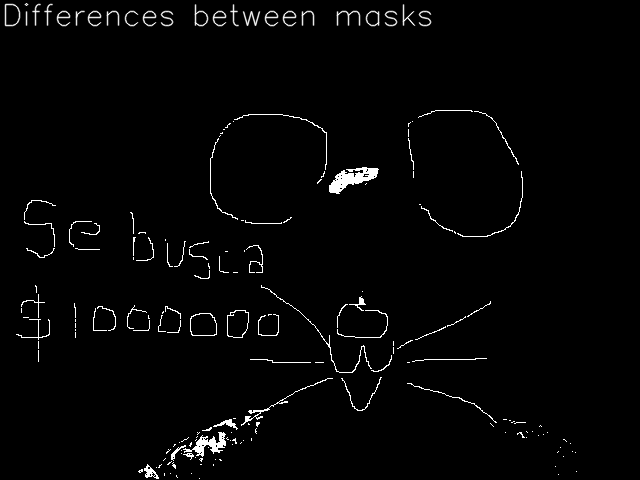

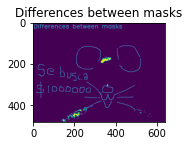

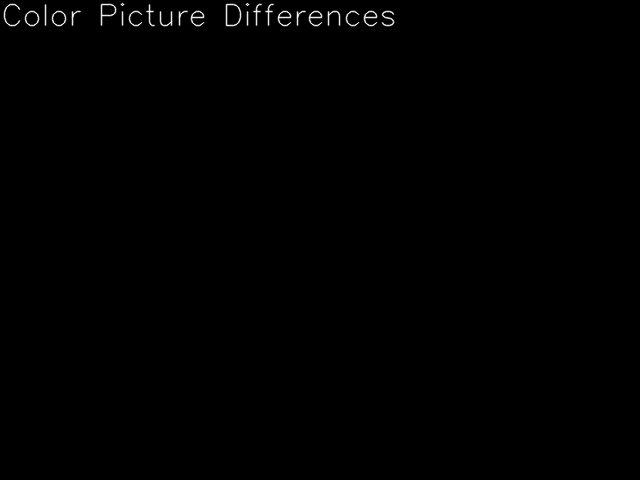

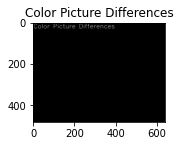

In [108]:
def main():
    global WINX, WINY

    fileName = IMAGE_PATH + "basePicture.jpg"
    originalImage = readImage(fileName, forceSize = True, width = WIDTH, height = HEIGHT)

    DISPLAY_TIME = 1
    displayImage(originalImage, title = fileName, x = WINX, y = WINY, waitTime = DISPLAY_TIME, plotImage = False,
                 keepImage = False)

    fileName = IMAGE_PATH + "thanos.jpeg"
    originalThanos = readImage(fileName, forceSize = True, width = WIDTH, height = HEIGHT)

    fileName = IMAGE_PATH + "spiderman.jpg"
    originalSpider = readImage(fileName, forceSize = True, width = WIDTH, height = HEIGHT)
    
    fileName = IMAGE_PATH + "hormigaatomica.jpeg"
    originalHormigaAtomica = readImage(fileName, forceSize = True, width = WIDTH, height = HEIGHT)
      
    fileName = IMAGE_PATH + "basePictureMouse.jpg"
    infectedImage, mask = extractMask(fileName, 245, 245)
    
    # Clone the image before altering it
    original_mask = mask.copy()
    mask = applyText(mask, text = "water mark mask", x = 1, y = 25, color = WHITE)
    displayImage(mask, title = fileName, x = WINX, y = WINY, waitTime = DISPLAY_TIME, plotImage = PLOT_IMAGE,
                 keepImage = True)

    embeddedWaterMark = applyWaterMark(originalImage, original_mask)
    embeddedWaterMarkMask = applyText(embeddedWaterMark, text = "embedded water mark", x = 1, y = 25, color = WHITE)
    displayImage(embeddedWaterMarkMask, title = "embedded water mark", x = WINX+600, y = WINY, waitTime = DISPLAY_TIME, plotImage = PLOT_IMAGE,
                 keepImage = True)

    originalThanosWaterMark = applyWaterMark(originalThanos, original_mask)
    originalThanosWaterMarkT = applyText(originalThanosWaterMark, text = "embedded water mark2", x = 1, y = 25, color = WHITE)
    displayImage(originalThanosWaterMarkT, title = "embedded water mark2", x = WINX, y = WINY, waitTime = DISPLAY_TIME, plotImage = PLOT_IMAGE,
                 keepImage = True)

    originalSpiderWaterMark = applyWaterMark(originalSpider, original_mask)
    originalSpiderWaterMarkT = applyText(originalSpiderWaterMark, text = "embedded water mark3", x = 1, y = 25, color = WHITE)
    displayImage(originalSpiderWaterMarkT, title = "embedded water mark3", x = WINX+600, y = WINY+350, waitTime = DISPLAY_TIME, plotImage = PLOT_IMAGE,
                 keepImage = True)

    originalHormigaAtomicaT = applyText(originalHormigaAtomica, text = "No embedded water mark", x = 1, y = 25, color = WHITE)
    displayImage(originalHormigaAtomica, title = "No embedded water mark", x = WINX, y = WINY+350, waitTime = DISPLAY_TIME, plotImage = PLOT_IMAGE,
                 keepImage = True)    

    cv2.waitKey(3000)
    analizeImage(embeddedWaterMark, originalImage, original_mask)
    analizeImage(originalThanosWaterMark, originalThanos, original_mask)
    analizeImage(originalSpiderWaterMark, originalSpider, original_mask)
    DISPLAY_TIME = 0
    analizeImage(originalHormigaAtomica, originalHormigaAtomica, original_mask)
    
    
main()
